In [1]:
# ------------------------------------------------------------------------- #
# Import libraries
# ------------------------------------------------------------------------- #
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import nlopt
import sys
from SiPANN import nn
from scipy import io as sio
from scipy.signal import find_peaks

INFO:tensorflow:Restoring parameters from /home/contagon/Documents/SiPANN/SiPANN/ANN/TIGHT_ANGLE_GAP/model
INFO:tensorflow:Restoring parameters from /home/contagon/Documents/SiPANN/SiPANN/ANN/TIGHT_ANGLE_STRAIGHT/model
INFO:tensorflow:Restoring parameters from /home/contagon/Documents/SiPANN/SiPANN/ANN/TIGHT_ANGLE_BENT_RAND/model


/home/contagon/anaconda3/envs/sipann/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 0.20.2 when using version 0.20.4. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/contagon/anaconda3/envs/sipann/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator LinearRegression from version 0.20.2 when using version 0.20.4. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/contagon/anaconda3/envs/sipann/lib/python3.7/site-packages/sklearn/base.py:253: UserWarning: Trying to unpickle estimator Pipeline from version 0.20.2 when using version 0.20.4. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [15]:
# ------------------------------------------------------------------------- #
# Tuning parameters
# ------------------------------------------------------------------------- #

# Initial algorithm starting points
radius        = 12
couplerLength = 4.5
gap           = 0.2
width         = 0.5
thickness     = 0.2

# Peak thresholding
peakThreshold = 0.3

# Value bounds
radiusMin        = 11;   radiusMax        = 13
couplerLengthMin = 4;    couplerLengthMax = 5
widthMin         = 0.45; widthMax         = 0.55
thicknessMin     = 0.18; thicknessMax     = 0.25

algorithmGlobal = nlopt.GN_DIRECT_L
algorithmLocal  = nlopt.LN_SBPLX

maxtime_global  = 120
maxtime_local   = 120

polyOrder = 3

In [16]:
# ------------------------------------------------------------------------- #
# Load relevant info
# ------------------------------------------------------------------------- #

# Load the measurement data
data       = sio.loadmat('test.mat')
power      = 10 ** (np.squeeze(data['powerMod']) / 10)
wavelength = np.squeeze(data['wavelength']) * 1e6

In [17]:
# ------------------------------------------------------------------------- #
# Preprocessing
# ------------------------------------------------------------------------- #

# Pull the coupler and loss data
a,b,w = nn.extractor(power,wavelength)

# Fit the coupler and loss data
ap = np.polyfit(w, a, polyOrder)
az = np.poly1d(ap)
bp = np.polyfit(w, b, polyOrder)
bz = np.poly1d(bp)

# Identify the peaks for the measurement data
peaks, _        = find_peaks(1-power,height=peakThreshold)
wavelengthPeaks = wavelength[peaks]
numPeaks        = peaks.size

In [18]:
# ------------------------------------------------------------------------- #
# Relevant functions
# ------------------------------------------------------------------------- #

def plotResult(radius,couplerLength,width,thickness):
    
    gap = 0.2

    E, alpha, t, _, _  = nn.racetrack_AP_RR_TF(wavelength,radius=radius,
    couplerLength=couplerLength,gap=gap,width=width,
    thickness=thickness)

    # get the transmission spectrum
    throughPort = np.abs(np.squeeze(E)) ** 2

    plt.figure()
    plt.plot(wavelength,power)
    plt.plot(wavelength,throughPort)
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Power (a.u.)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    return

# Define a cost function that can locate the correct FSR
def costFunction_FSR(x,grad):
    radius        = x[0]
    couplerLength = x[1]
    gap           = 0.2
    width         = x[2]
    thickness     = x[3]

    # Evaluate the functin
    E, alpha, t, _, _ = nn.racetrack_AP_RR_TF(wavelength,radius=radius,
    couplerLength=couplerLength,gap=gap,width=width,
    thickness=thickness)

    # get the transmission spectrum
    throughPort = np.abs(np.squeeze(E)) ** 2

    # Pull the peaks from the simulation
    peaksSim, _ = find_peaks(1-throughPort,height=peakThreshold)
    
    #plt.figure()
    #plt.plot(wavelength,throughPort)
    #plt.plot(wavelength[peaksSim],throughPort[peaksSim],'x')
    #plt.show()

    # calculate the number of peaks
    wavelengthSim = wavelength[peaksSim]
    powerSim      = throughPort[peaksSim]
    

    if wavelengthSim.size > numPeaks:
        wavelengthSim = wavelengthSim[0:numPeaks]
        powerSim      = powerSim[0:numPeaks]
    elif wavelengthSim.size < numPeaks:
        wavelengthSim = np.append(wavelengthSim,np.zeros((numPeaks-wavelengthSim.size,)))
        powerSim      = np.append(powerSim,np.zeros((numPeaks-powerSim.size,)))
    # Estimate the error
    error = np.sum(np.abs(wavelengthSim - wavelengthPeaks) ** 2)
    print(error)
    return error

def costFunction_loss(params,gapA,x,grad):
    radius        = params[0]
    couplerLength = params[1]
    gap           = gapA[0]
    width         = params[2]
    thickness     = params[3]

    # Evaluate the functin
    E, alpha, t, _, _  = nn.racetrack_AP_RR_TF(wavelength,radius=radius,
    couplerLength=couplerLength,gap=gap,width=width,
    thickness=thickness,loss=x)

    throughPort = np.abs(np.squeeze(E)) ** 2

    ap_sim = np.polyfit(wavelength, alpha, polyOrder)
    az_sim = np.poly1d(ap_sim)

    error = np.mean(np.abs(az_sim(wavelength)-az(wavelength)) ** 2 )
    
    print(error)
    plt.figure()
    plt.plot(w,a,'o')
    plt.plot(wavelength,az_sim(wavelength))

    plt.show()

    return error 
def costFunction_coupling(params,x,grad):
    radius        = params[0]
    couplerLength = params[1]
    gap           = x[0]
    width         = params[2]
    thickness     = params[3]

    # Evaluate the functin
    E, alpha, t, _, _  = nn.racetrack_AP_RR_TF(wavelength,radius=radius,
    couplerLength=couplerLength,gap=gap,width=width,
    thickness=thickness)

    throughPort = np.abs(np.squeeze(E)) ** 2

    bp_sim = np.polyfit(wavelength, t, polyOrder)
    bz_sim = np.poly1d(bp_sim)

    error = np.mean(np.abs(bz_sim(w)-b) ** 2 )
    print(error)
    plt.figure()
    plt.plot(w,b,'o')
    plt.plot(wavelength,bz_sim(wavelength))

    plt.show()

    return error
def plotFinal(x0,y0,z0):
    radius        = x0[0]
    couplerLength = x0[1]
    gap           = y0[0]
    width         = x0[2]
    thickness     = x0[3]
    loss          = z0

    E, alpha, t, _, _  = nn.racetrack_AP_RR_TF(wavelength,radius=radius,
    couplerLength=couplerLength,gap=gap,width=width,
    thickness=thickness,loss=loss)

    # get the transmission spectrum
    throughPort = np.abs(np.squeeze(E)) ** 2

    plt.figure(figsize=(7,7))
    plt.subplot(2,2,1)
    plt.plot(wavelength,power)
    plt.plot(wavelength,throughPort,'--')
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Power (a.u.)')
    plt.grid(True)
    
    plt.subplot(2,2,3)
    plt.plot(wavelength,10*np.log10(power))
    plt.plot(wavelength,10*np.log10(throughPort),'--')
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Power (dB)')
    plt.grid(True)
    
    plt.subplot(2,2,2)
    plt.plot(wavelength,power,'o')
    plt.plot(wavelength,throughPort)
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Power (a.u.)')
    plt.grid(True)
    plt.xlim(1.552,1.554)
    
    plt.subplot(2,2,4)
    plt.plot(wavelength,10*np.log10(power),'o')
    plt.plot(wavelength,10*np.log10(throughPort))
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Power (dB)')
    plt.grid(True)
    plt.xlim(1.552,1.554)

    plt.tight_layout()
    plt.savefig('results.png')
    plt.show()
    return
    return

In [6]:
# ------------------------------------------------------------------------- #
# Step 1: Find the right FSR
# ------------------------------------------------------------------------- #
print('=================')
print('FSR')


lowerBounds = [radiusMin,couplerLengthMin,widthMin,thicknessMin]
upperBounds = [radiusMax,couplerLengthMax,widthMax,thicknessMax]
x0          = [radius,couplerLength,width,thickness]

numParams = len(x0)

# Do a global optimization first
opt = nlopt.opt(algorithmGlobal, numParams)
opt.set_lower_bounds(lowerBounds)
opt.set_upper_bounds(upperBounds)
opt.set_min_objective(costFunction_FSR)
opt.set_maxtime(maxtime_global)
x0 = opt.optimize(x0)
print('=================')
print('Global')
print(x0)
print(costFunction_FSR(x0,0))

# Then do a local optimization
opt = nlopt.opt(algorithmLocal, numParams)
opt.set_lower_bounds(lowerBounds)
opt.set_upper_bounds(upperBounds)
opt.set_min_objective(costFunction_FSR)
opt.set_maxtime(maxtime_local)
x0 = opt.optimize(x0)
print('=================')
print('Local')
print(x0)
print(costFunction_FSR(x0,0))

FSR
2.550000000001881e-08
8.82674999999994e-05
6.794360000000084e-05
4.4447999999994e-06
3.964200000000355e-06
3.923600000000139e-06
0.00012477960000000323
0.0003041178999999996
0.0001538401000000001
0.00039638179999999904
4.1012400000001674e-05
0.0002757496000000011
8.439150000000253e-05
4.720900000000283e-06
1.316739999999918e-05
7.030690000000038e-05
0.00022352990000000053
0.00018570729999999882
0.00011678850000000075
1.537000000000066e-07
1.356170000000137e-05
0.00031328150000000245
0.00022432010000000374
4.3189700000001705e-05
0.00036760209999999913
9.239999999999981e-06
9.50400000000062e-06
0.00032507740000000144
5.711020000000167e-05
0.00013580880000000066
0.00019138889999999886
0.00015871620000000125
0.0001360331000000023
0.00030349769999999873
0.00015852700000000292
0.00037528130000000014
4.120370000000005e-05
1.0108999999998206e-06
1.1098999999999673e-06
6.312500000000029e-06
6.545800000000545e-06
0.00044517130000000575
2.171609999999968e-05
2.4767150160000004
2.8395200000000

Coupling
0.0016547846569769972


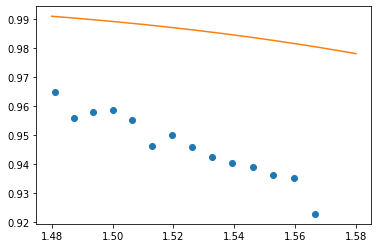

0.0026223621268996835


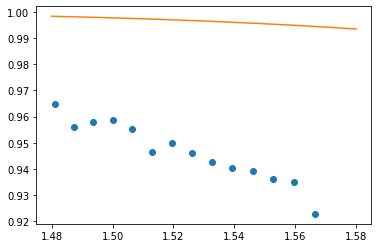

0.00032761010672784156


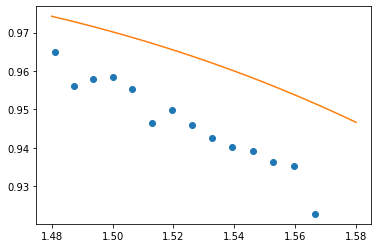

0.001178691453299128


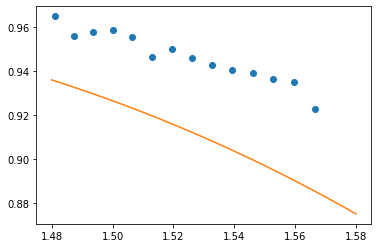

0.001178691453299128


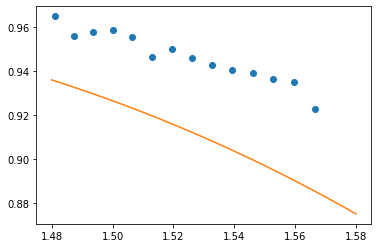

8.663489420142358e-06


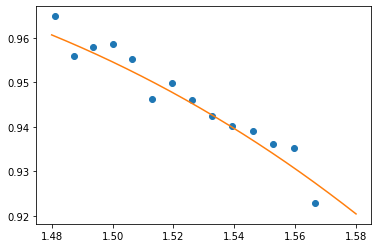

0.001178691453299128


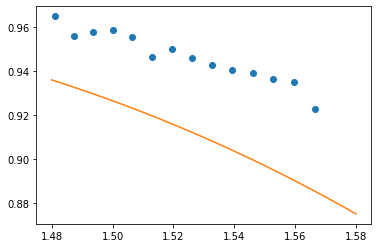

0.00010013440271998377


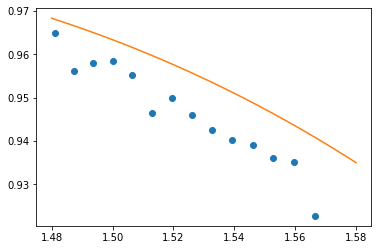

0.00022736132653701624


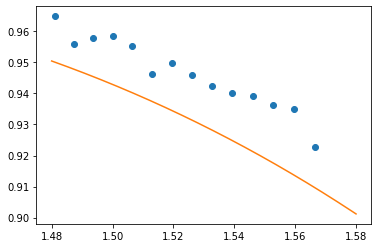

0.00010013440271998377


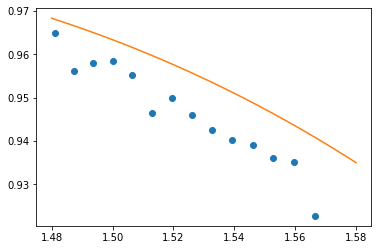

3.00961474058065e-05


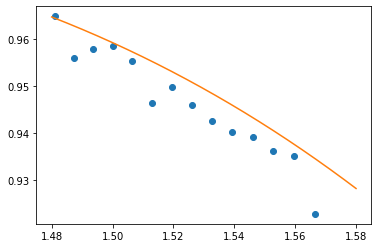

6.12132197305588e-05


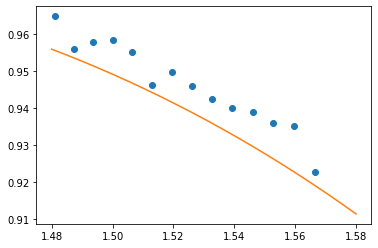

1.1983851143857904e-05


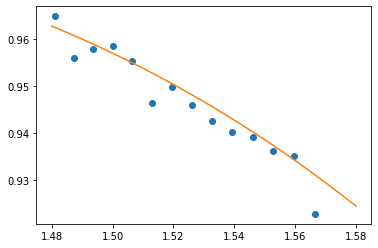

2.362101216074651e-05


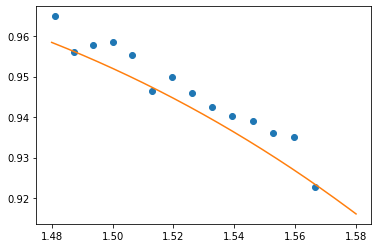

8.275090426186824e-06


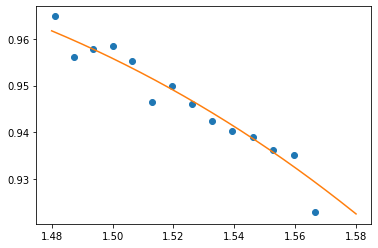

1.9379661749356316e-05


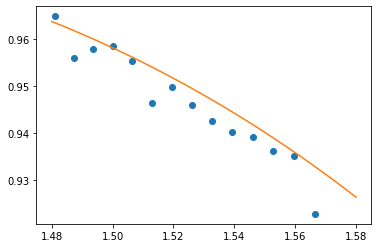

1.3607826242602604e-05


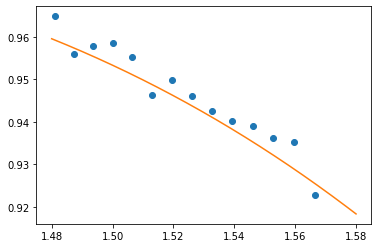

8.663489420142358e-06


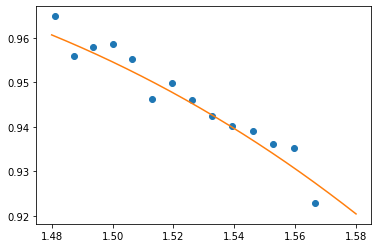

1.198385114399035e-05


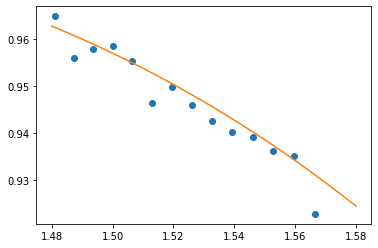

7.929673300190004e-06


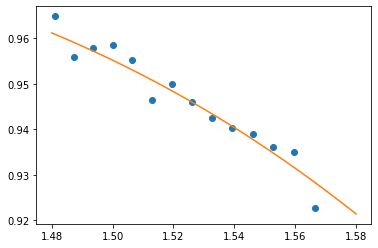

8.663489420082113e-06


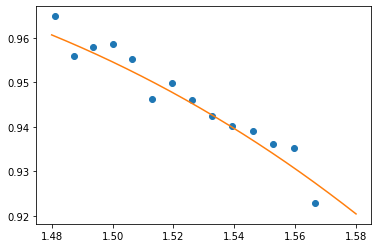

7.971032227838943e-06


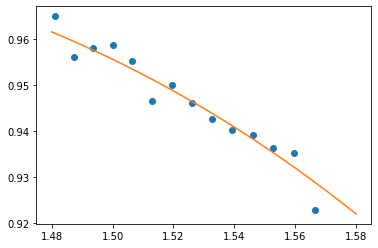

8.663489420082113e-06


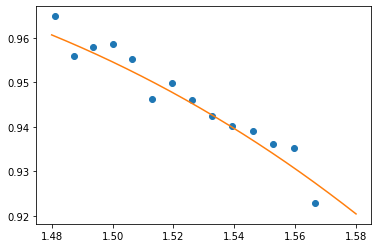

8.275090426186824e-06


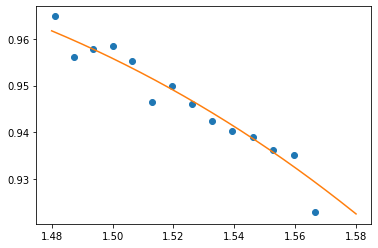

7.971032227838943e-06


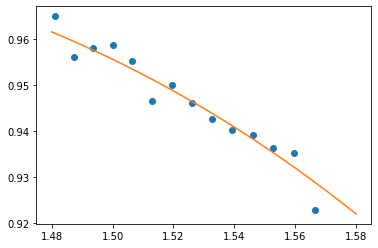

8.158072641488238e-06


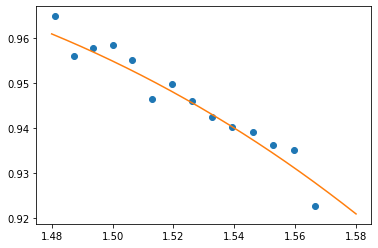

7.917078797058431e-06


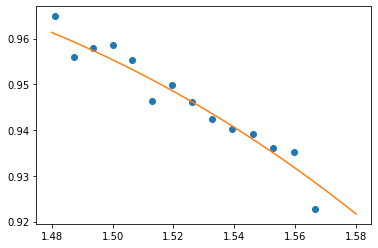

7.971032227823675e-06


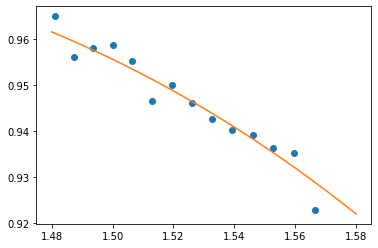

7.929673300190004e-06


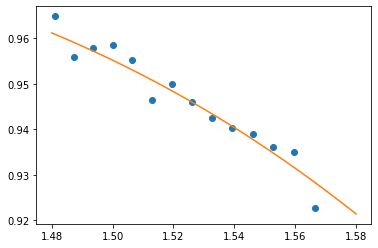

7.915002316447028e-06


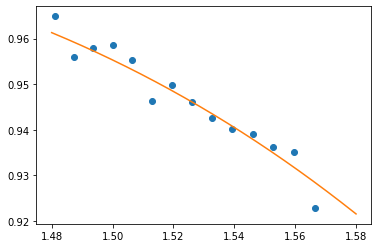

7.929673300190004e-06


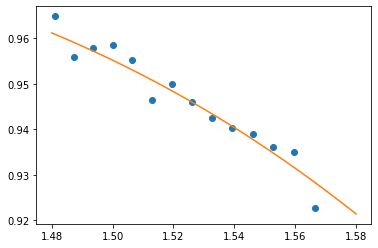

7.913954059067106e-06


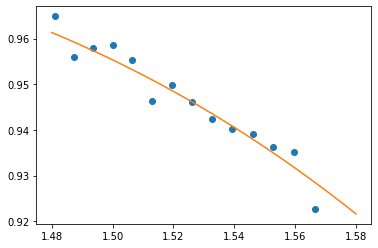

7.915002316444641e-06


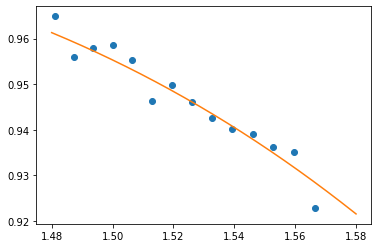

7.917078797058431e-06


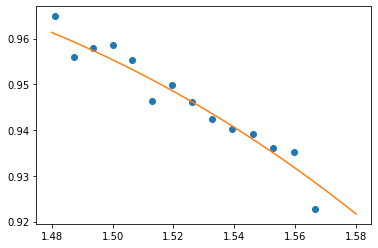

7.913955698462538e-06


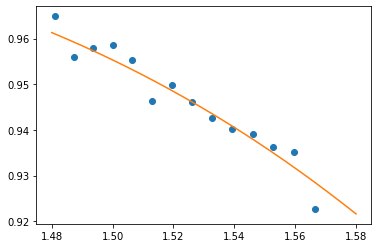

7.914995667785696e-06


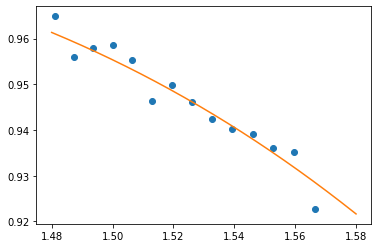

7.913824364486611e-06


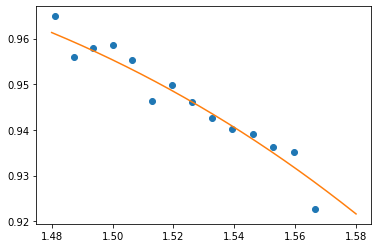

7.91395569850401e-06


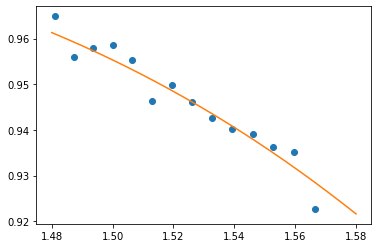

7.913954059067106e-06


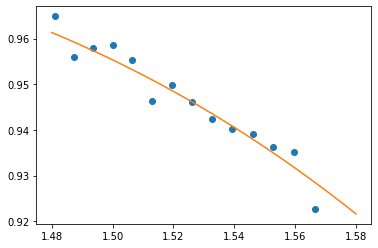

7.913856596780992e-06


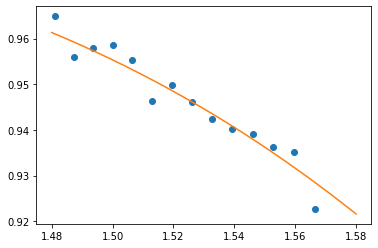

7.913857389375492e-06


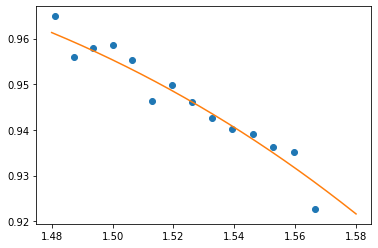

7.913832325281016e-06


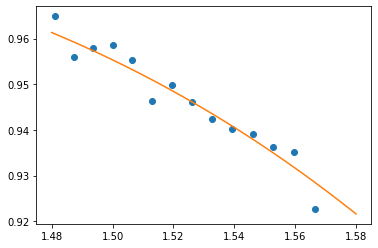

7.913832718274494e-06


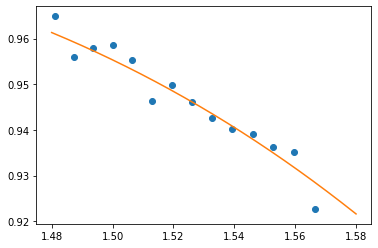

7.913826305977836e-06


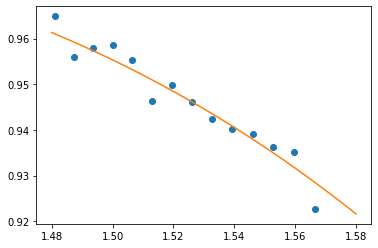

7.913832325281016e-06


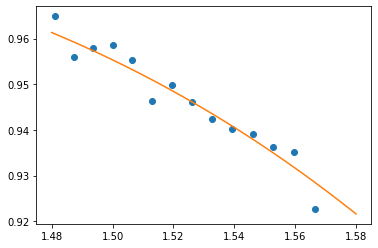

7.913832718274494e-06


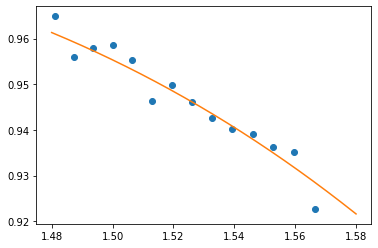

7.913826305977836e-06


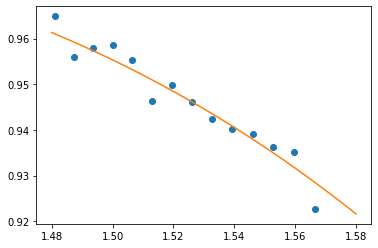

7.913826502035144e-06


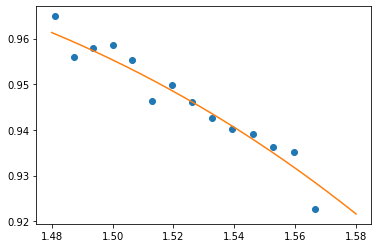

7.913824825340797e-06


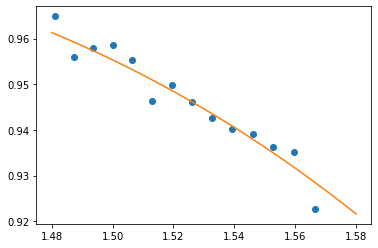

7.913824923518548e-06


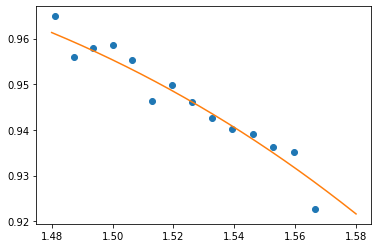

7.913824825340797e-06


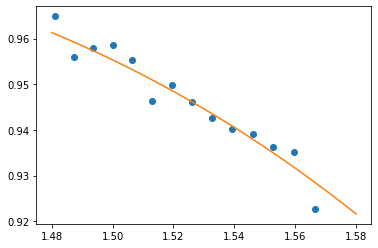

7.91382446762156e-06


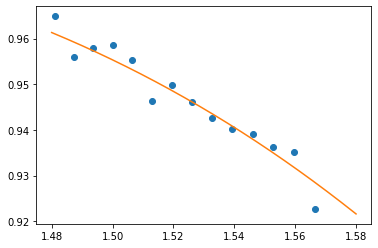

7.913824516521085e-06


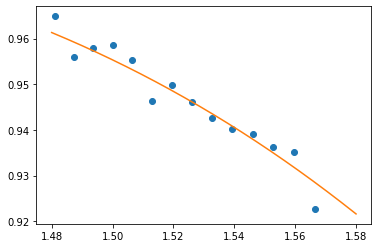

7.913824384148557e-06


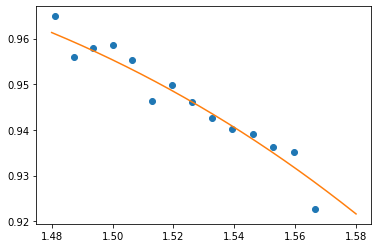

7.913824408697484e-06


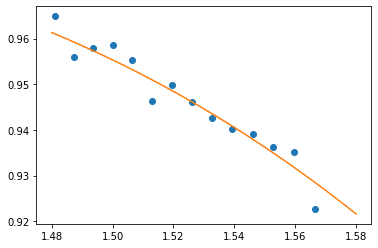

7.91382436633189e-06


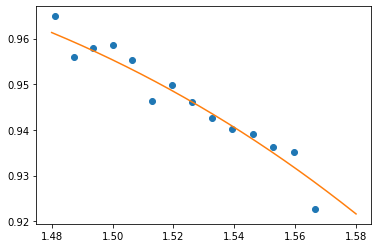

7.913824384148557e-06


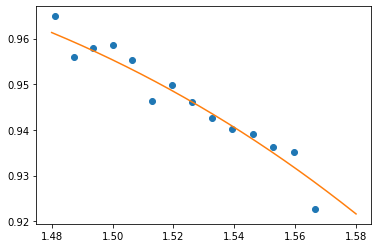

7.913824408697484e-06


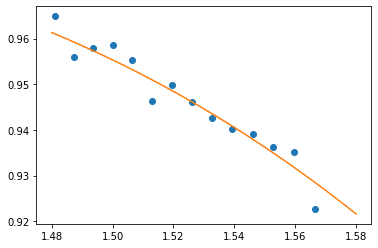

7.91382436633189e-06


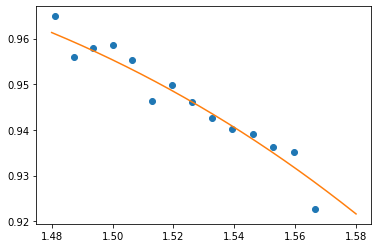

7.91382437846496e-06


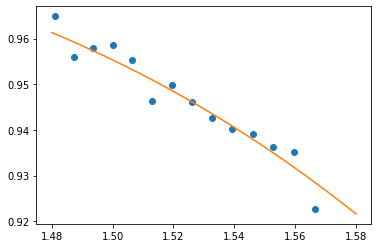

7.913824363518019e-06


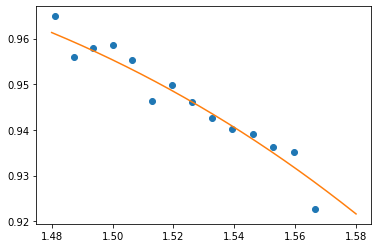

7.913824366343933e-06


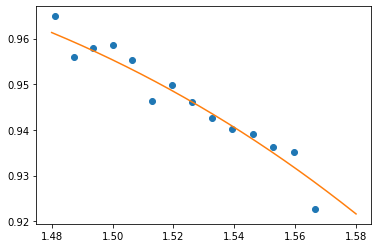

7.913824364486611e-06


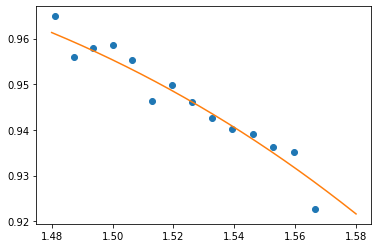

7.913824363621543e-06


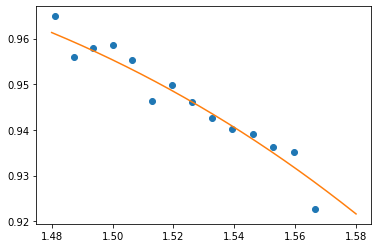

7.913824364518163e-06


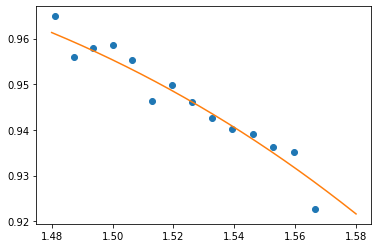

7.913824363493362e-06


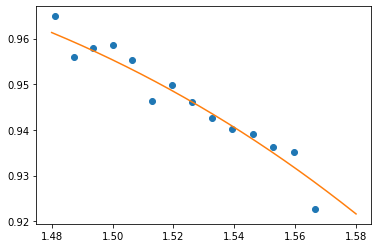

7.913824363661412e-06


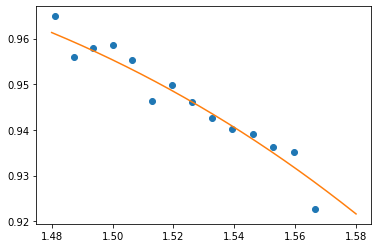

7.913824363302678e-06


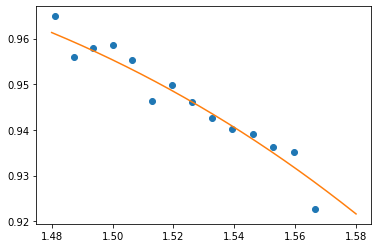

7.913824363445774e-06


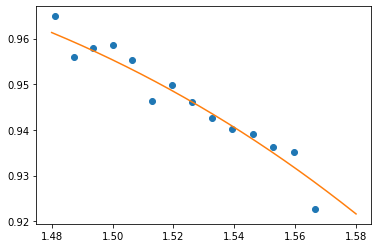

7.913824363749776e-06


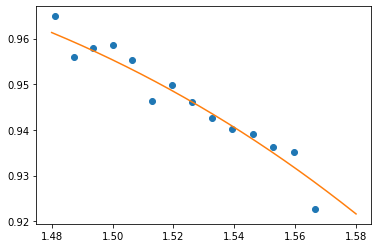

7.913824363493362e-06


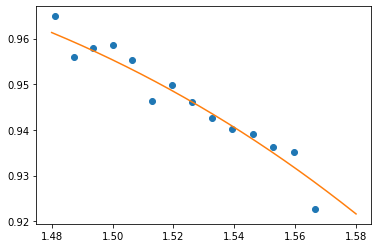

7.913824363493362e-06


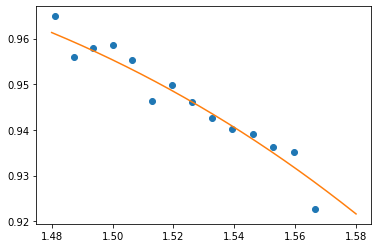

7.913824363518019e-06


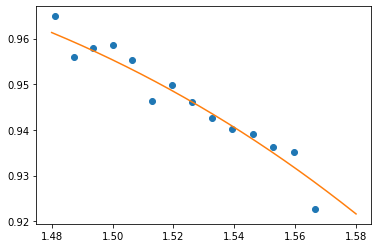

7.913824363433717e-06


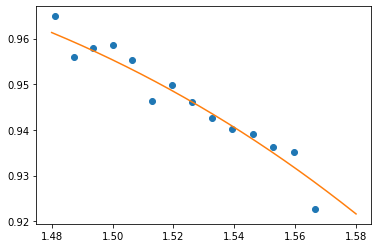

7.913824363442013e-06


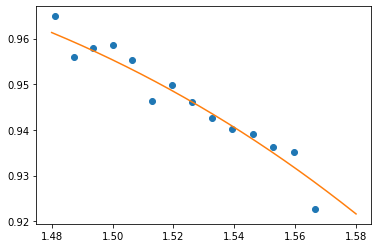

7.913824363580413e-06


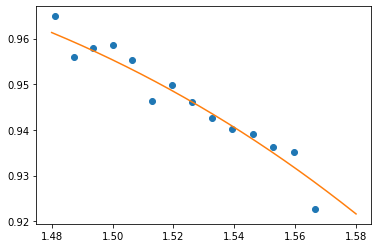

7.913824363580413e-06


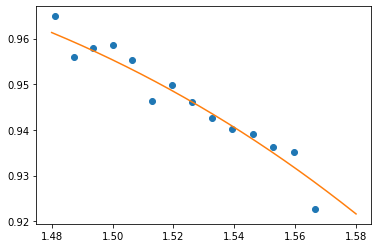

7.913824363466062e-06


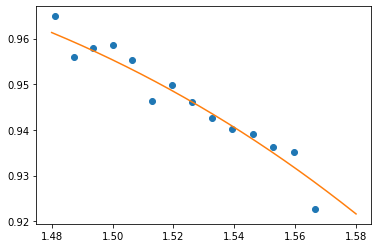

7.91382436345151e-06


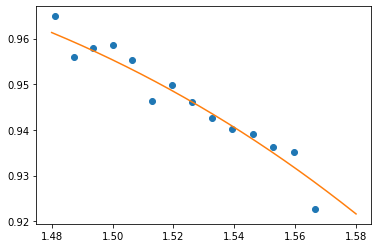

7.913824363580413e-06


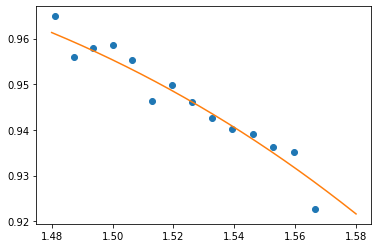

7.913824363446299e-06


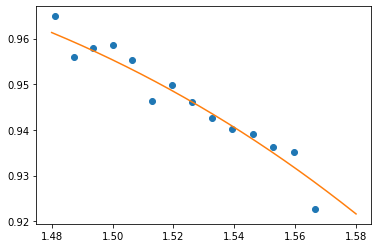

7.913824363580413e-06


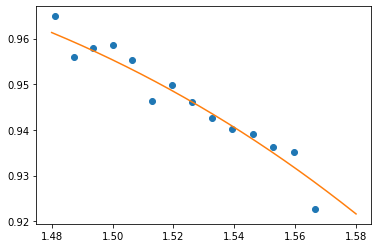

7.913824363398144e-06


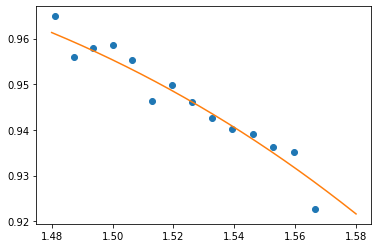

7.913824363526842e-06


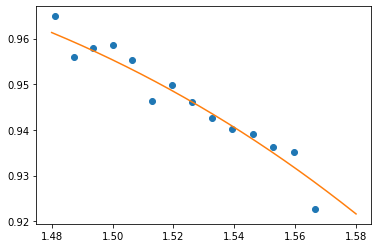

7.913824363374345e-06


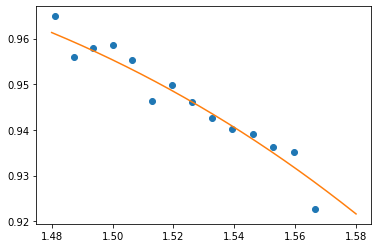

7.913824363430356e-06


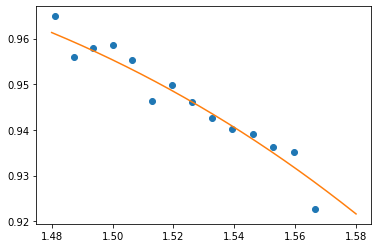

7.913824363435362e-06


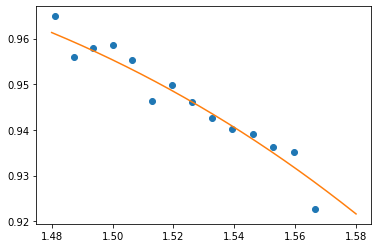

7.913824363430356e-06


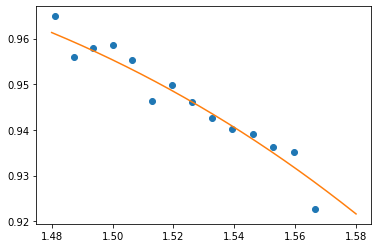

7.913824363386868e-06


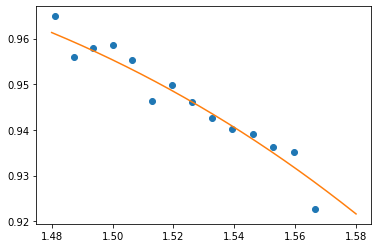

7.913824363405816e-06


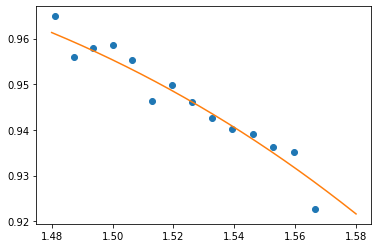

7.913824363413163e-06


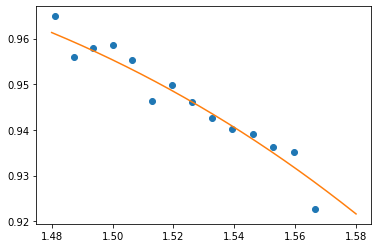

7.913824363413163e-06


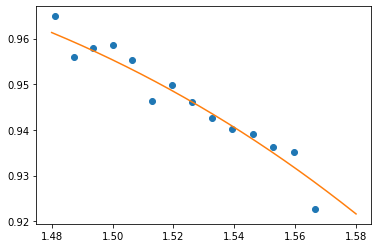

7.913824363420791e-06


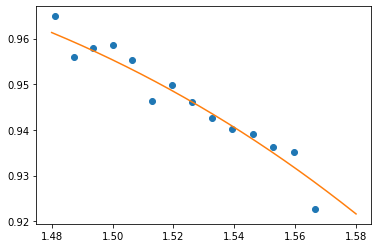

7.913824363425042e-06


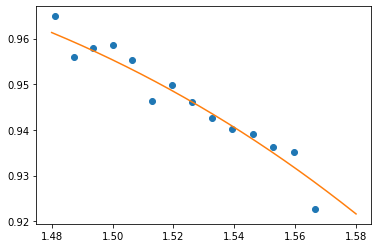

7.913824363413163e-06


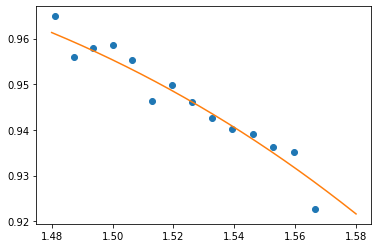

7.913824363543545e-06


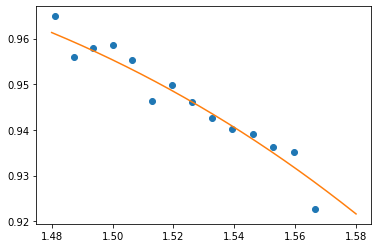

7.913824363412223e-06


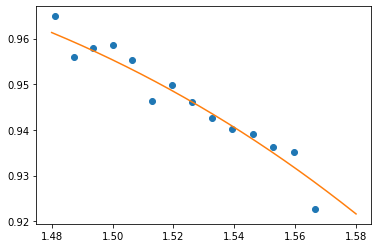

7.913824363410583e-06


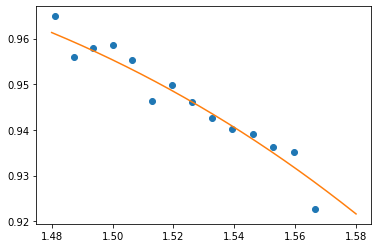

7.913824363403275e-06


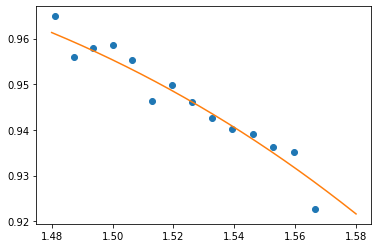

7.91382436344098e-06


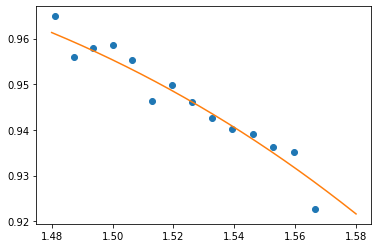

7.913824363414783e-06


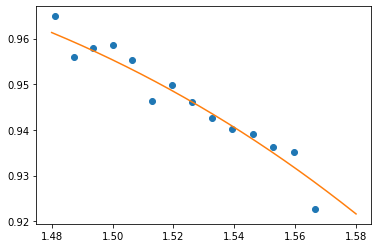

7.91382436344098e-06


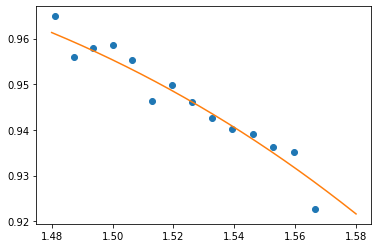

7.913824363410507e-06


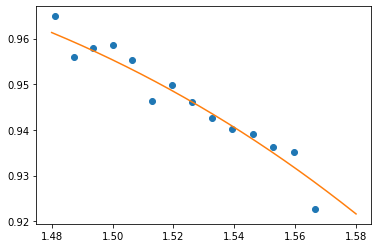

7.913824363508644e-06


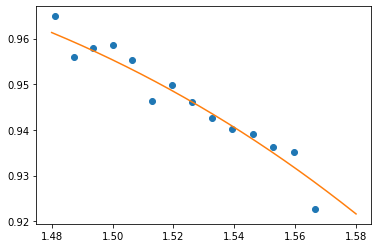

7.913824363502503e-06


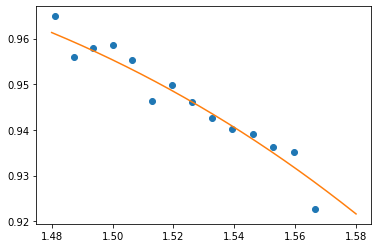

7.913824363502503e-06


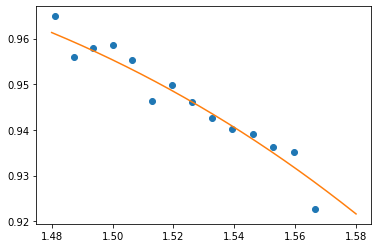

7.913824363527873e-06


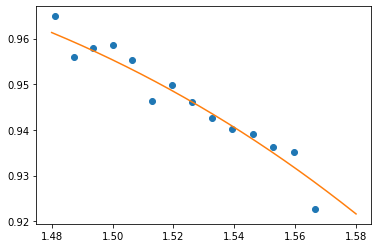

7.913824363436617e-06


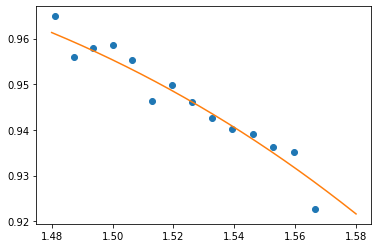

7.913824363502503e-06


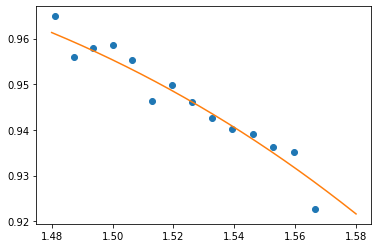

7.913824363423283e-06


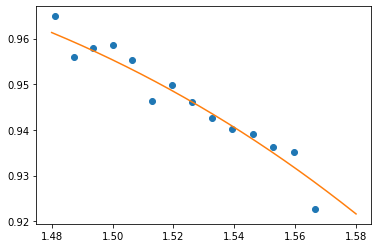

7.913824363502503e-06


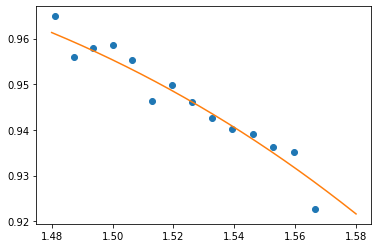

7.913824363432436e-06


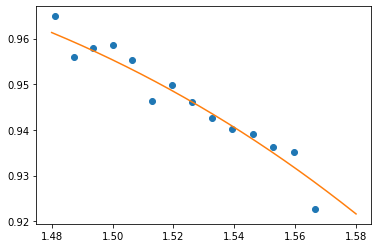

7.913824363432436e-06


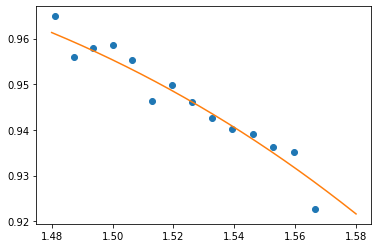

7.913824363384815e-06


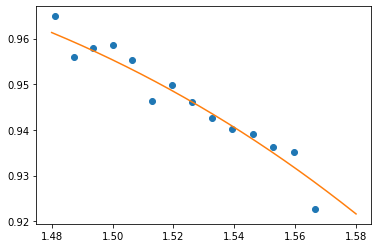

7.913824363458246e-06


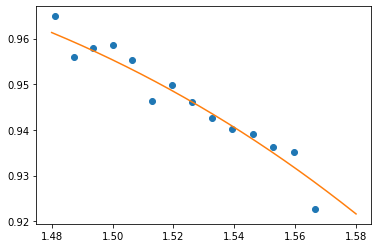

7.913824363448552e-06


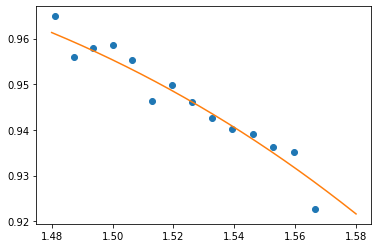

7.913824363448552e-06


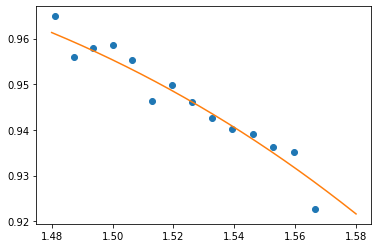

7.913824363556186e-06


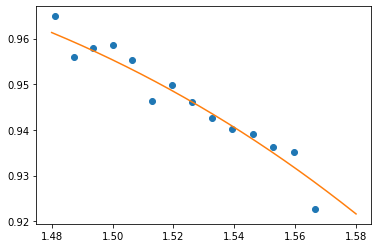

7.913824363427366e-06


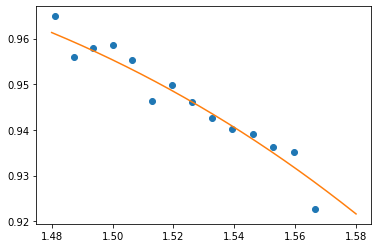

7.913824363431991e-06


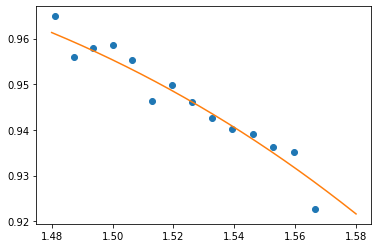

7.913824363413622e-06


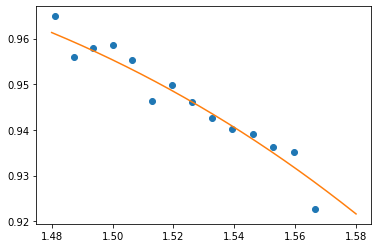

7.913824363487899e-06


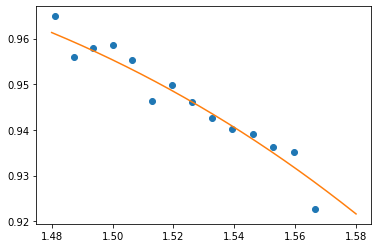

7.91382436336533e-06


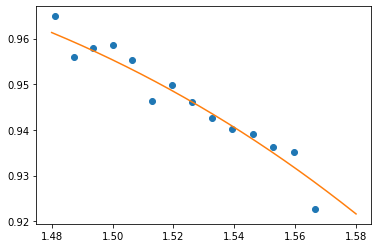

7.913824363413622e-06


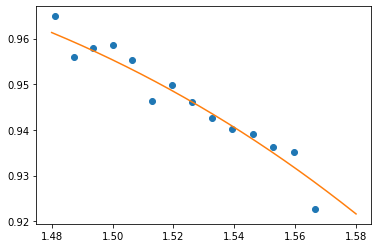

7.913824363459935e-06


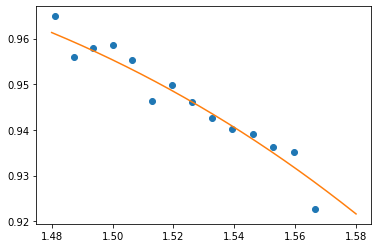

7.913824363413622e-06


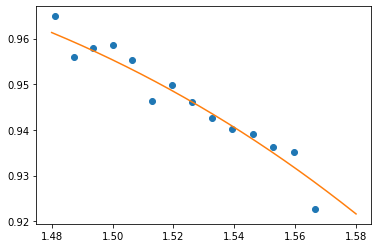

7.913824363301992e-06


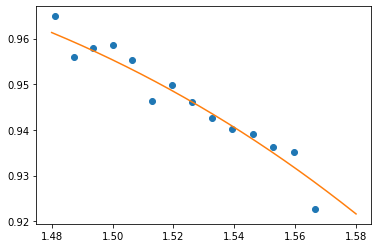

7.913824363413622e-06


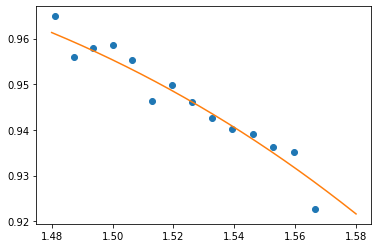

7.913824363323552e-06


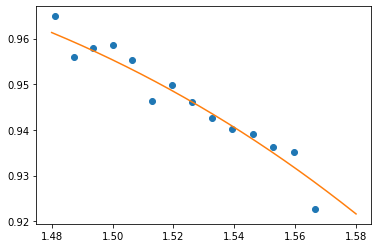

7.913824363539862e-06


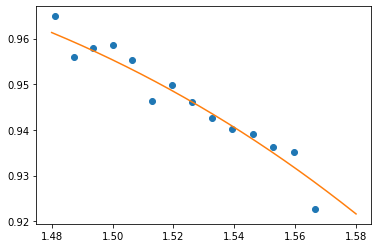

7.913824363459054e-06


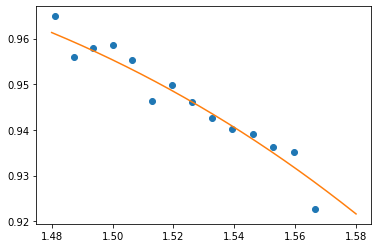

7.913824363539862e-06


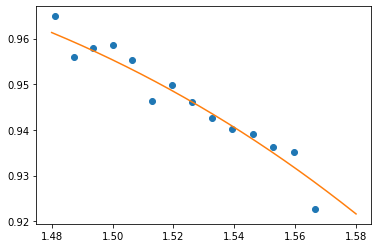

7.913824363518487e-06


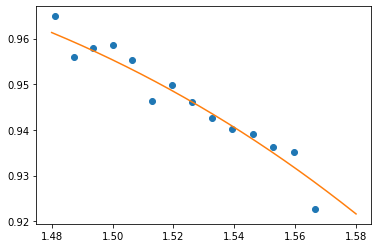

7.913824363518487e-06


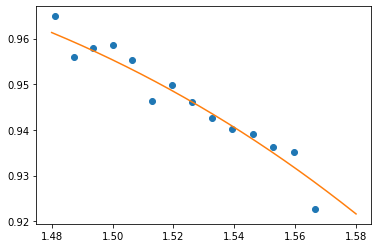

7.913824363571643e-06


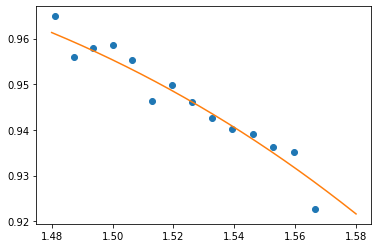

7.913824363518487e-06


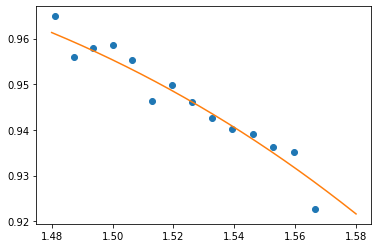

Local
[0.12591557]
7.913824363301992e-06


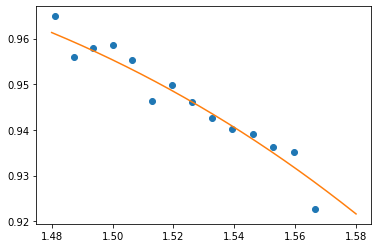

7.913824363301992e-06


In [9]:
# ------------------------------------------------------------------------- #
# Step 2: Find the right coupling
# ------------------------------------------------------------------------- #
print('===============')
print('Coupling')

costFunction_coupling_mode = lambda x_param,grad: costFunction_coupling(x0,x_param,grad)

lowerBounds = [0.1]
upperBounds = [0.3]
y0 = [0.2]
numParams = len(y0)

opt = nlopt.opt(algorithmLocal, numParams)
opt.set_lower_bounds(lowerBounds)
opt.set_upper_bounds(upperBounds)
opt.set_min_objective(costFunction_coupling_mode)
opt.set_maxtime(maxtime_local)
y0 = opt.optimize(y0)
print('=================')
print('Local')
print(y0)
print(costFunction_coupling_mode(y0,0))

Loss
Local
[  9.27729299 -37.26335587  48.83695709 -19.75945442]
2.767413345640768e-28


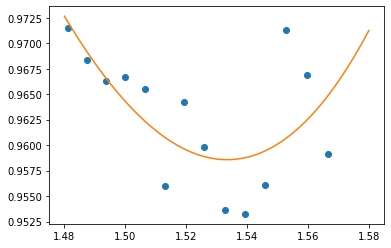

2.767413345640768e-28


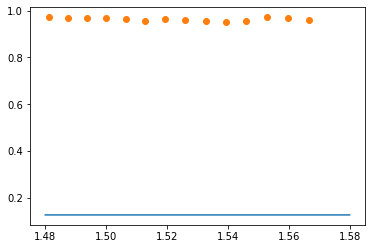

In [19]:
# ------------------------------------------------------------------------- #
# Step 3: Find the right loss
# ------------------------------------------------------------------------- #
print('==============')
print('Loss')

costFunction_loss_mode = lambda x_param,grad: costFunction_loss(x0,y0,x_param,grad)
lowerBounds = np.zeros((polyOrder+1,)) - 100
upperBounds = np.zeros((polyOrder+1,)) + 100
z0          = ap

numParams = len(z0)

# Just do a local optimization
opt = nlopt.opt(algorithmLocal, numParams)
opt.set_lower_bounds(lowerBounds)
opt.set_upper_bounds(upperBounds)
opt.set_min_objective(costFunction_loss_mode)
opt.set_maxtime(maxtime_local)
#z0 = opt.optimize(z0)
print('=================')
print('Local')
print(z0)
print(costFunction_loss_mode(z0,0))

E, alpha, t, _, _  = nn.racetrack_AP_RR_TF(wavelength,radius=x0[0],
couplerLength=x0[1],gap=y0[0],width=x0[2],
thickness=x0[3],loss=y0)

throughPort = np.abs(np.squeeze(E)) ** 2

ap_sim = np.polyfit(wavelength, alpha, polyOrder)
az_sim = np.poly1d(ap_sim)
plt.figure()
plt.plot(wavelength,az_sim(wavelength))
plt.plot(w,a,'o')
plt.show()

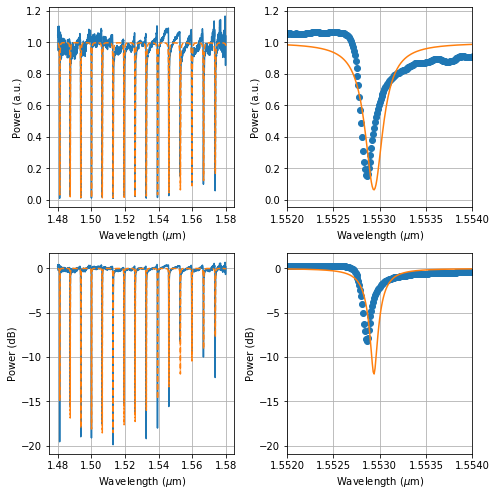

In [20]:
plotFinal(x0,y0,z0)

In [24]:
E, alpha, t, alpha_s, phi  = nn.racetrack_AP_RR_TF(wavelength,radius=x0[0],
couplerLength=x0[1],gap=y0[0],width=x0[2],
thickness=x0[3],loss=y0)

In [27]:
for i in temp:
    print(i.dtype)

complex128
float64
float64
float64
float64


In [26]:
wavelength.shape

(10001,)